# Import

In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from ad_plotting import bar_plot, open_pickle

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from decimal import Decimal

from docx import Document

In [4]:


def sigbars(xy_left, xy_right, height, label_height=0.25, label='*', linewidth=1, color='k', pyplot_obj = plt, fontsize=10):
    # Makes a significance bar between xy_left and xy_right
    x_left = xy_left[0]
    x_right = xy_right[0]
    y_left = xy_left[1]
    y_right = xy_right[1]
    
    #Calculate distances
    y_max = np.maximum(y_left, y_right)+height
    x_middle = (x_left+ x_right)/2
    y_label = y_max+label_height  
    
    
    pyplot_obj.vlines(x_left, y_left, y_max, linewidth=linewidth, color=color)
    pyplot_obj.vlines(x_right, y_right, y_max, linewidth=linewidth, color=color)
    pyplot_obj.hlines(y_max, x_left, x_right, linewidth=linewidth, color=color)
    
    pyplot_obj.annotate(label, (x_middle, y_label), ha='center', fontsize=fontsize)



def to_scientific_notation(value):
    """Converts a decimal to scientific notation and returns the base and exponent"""
    sci_notation = "{:.2e}".format(value)
    base, exponent = sci_notation.split('e')
    exponent = str(int(exponent))
    return base, exponent

    
def to_scientific_notation_str(value):
    """Courtesy of ChatGPT, converts decimal number to scientific notation with nice formatting"""
    sci_notation = "{:.3e}".format(value)
    base, exponent = sci_notation.split('e')
    exponent = int(exponent)
    superscript_mapping = str.maketrans('-0123456789', '⁻⁰¹²³⁴⁵⁶⁷⁸⁹')
    superscript_exponent = str(exponent).translate(superscript_mapping)
    return f"{base} × 10{superscript_exponent}"

def to_subscript(text):
    subscript_mapping = str.maketrans('0123456789(),', '₀₁₂₃₄₅₆₇₈₉₍₎,')
    return text.translate(subscript_mapping)



def create_holder(*keys):
    """Create a dictionary with specified keys, each initialized with an empty list. Good for holding seaborn data
        *keys: Variable number of keys to include in the dictionary.
    """
    return {key: [] for key in keys}

def fill_holder(holder_dict, values_to_add):
    """Convenience function that appends values to a holder dict (made by create_holder)
    Inputs:
    holder_dict: created by create_holder
    values_to_add (list): list of items to add to holder, must be the same length and order as the keys in holder_dict"""

    for ix, item in enumerate(holder_dict.items()):
        key, val = item
        val.append(values_to_add[ix])


def add_formatted_text(cell, parts):
    """
    Add formatted text to a cell.
    `parts` is a list of tuples where each tuple contains the text and its formatting type:
    ('text', 'normal'/'subscript'/'superscript')
    """
    p = cell.paragraphs[0] if cell.paragraphs else cell.add_paragraph()
    for text, fmt in parts:
        run = p.add_run(text)
        if fmt == 'superscript':
            run.font.superscript = True
        elif fmt == 'subscript':
            run.font.subscript = True


### S2A

In [5]:
df_ncells = pd.read_csv('Data/animal_data_table.csv', index_col=False)
df_ncells['factor'] = df_ncells['genotype'] + ' ' + df_ncells['treatment']
df_ncells = df_ncells.sort_values('factor', ascending=False)

In [6]:
factors = df_ncells.factor.unique().astype(str)
ncells_grouped = df_ncells.groupby('factor')['num_cells'].apply(list)
ncells_list = [ncells_grouped[i] for i in factors]
labels = ["LDA", "LR", "SVM", "NN_shuffle_label", "NN_shuffle_cell", "NN_25_cell", "NN_50_cell", "NN_2%", "NN"]


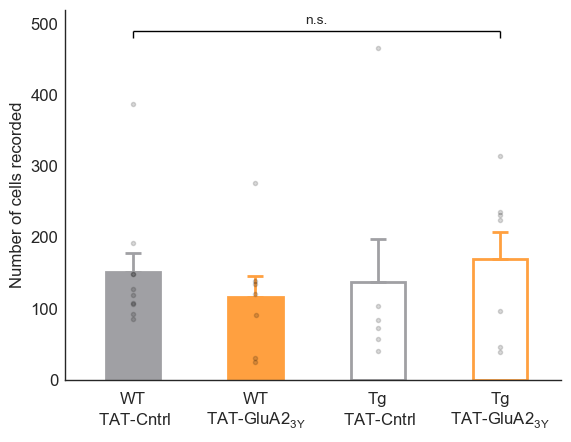

In [7]:
ax = plt.axes()
bar_plot([ncells_list], [labels[3]], ax=ax, ylabel="Number of cells recorded", show_data=True, ylim=[0,520], show_legend=False, 
         paired="condition", show_lines=True, show_stat=False, label_stat=False, extra_legend_pos = 10, jitter_scale = 0.1, show_sample_size=False)
sigbars([0,480], [4.5,480], 10, label_height=10, label='n.s.')
#plt.savefig('S2A - num cells.svg', dpi=1080, bbox_inches='tight')

#### Stats

In [8]:
model = ols('num_cells ~ C(factor) ', data=df_ncells).fit()
res = sm.stats.anova_lm(model, typ=2)
res

,sum_sq,df,F,PR(>F)
C(factor),10786.295238,3.0,0.294598,0.828923
Residual,317318.004762,26.0,NaN,NaN


In [9]:
deg_freedom = res['df'].values.astype(int)
fval = res['F']['C(factor)']
pval = res['PR(>F)']['C(factor)']

s2a_stats = pd.DataFrame(columns = ['df', 'F', 'p'], data = [[deg_freedom, fval, pval]])

### S2C 

In [10]:
df_restricted_cells_trials = pd.read_csv('Data/classifier_bacc_restricted_cells_and_trials.csv')

In [11]:
condition_order = ['WT-Veh', 'WT-GluA2', 'Tg-Veh', 'Tg-GluA2']
classifier_order = ['LDA', 'NB', 'QDA', 'NN', 'SVM']
cell_trial_order = ['c10', 'c25', 'c100', 'baseline']

In [12]:
cell_trial_order = ['c10', 'c25', 'c100', 'baseline', 't600', 'c25_t600', 't600_updated', 't1000']

chen_plot_trial_dict = {}

for trial_ix, cell_trial in enumerate(cell_trial_order):
    trial_list = []
    for class_ix, classifier in enumerate(classifier_order):
        subdf = df_restricted_cells_trials.query("cell_trial == @cell_trial  and classifier == @classifier")
        # Here we groupby condition, get the bacc, convert it to a list, reorder the conditions, then make the whole thing into a list of lists
        bacc_list = subdf.groupby('cond')['bacc'].apply(list).reindex(condition_order, level='cond').tolist() 
        trial_list.append(bacc_list)
    chen_plot_trial_dict[cell_trial] = trial_list

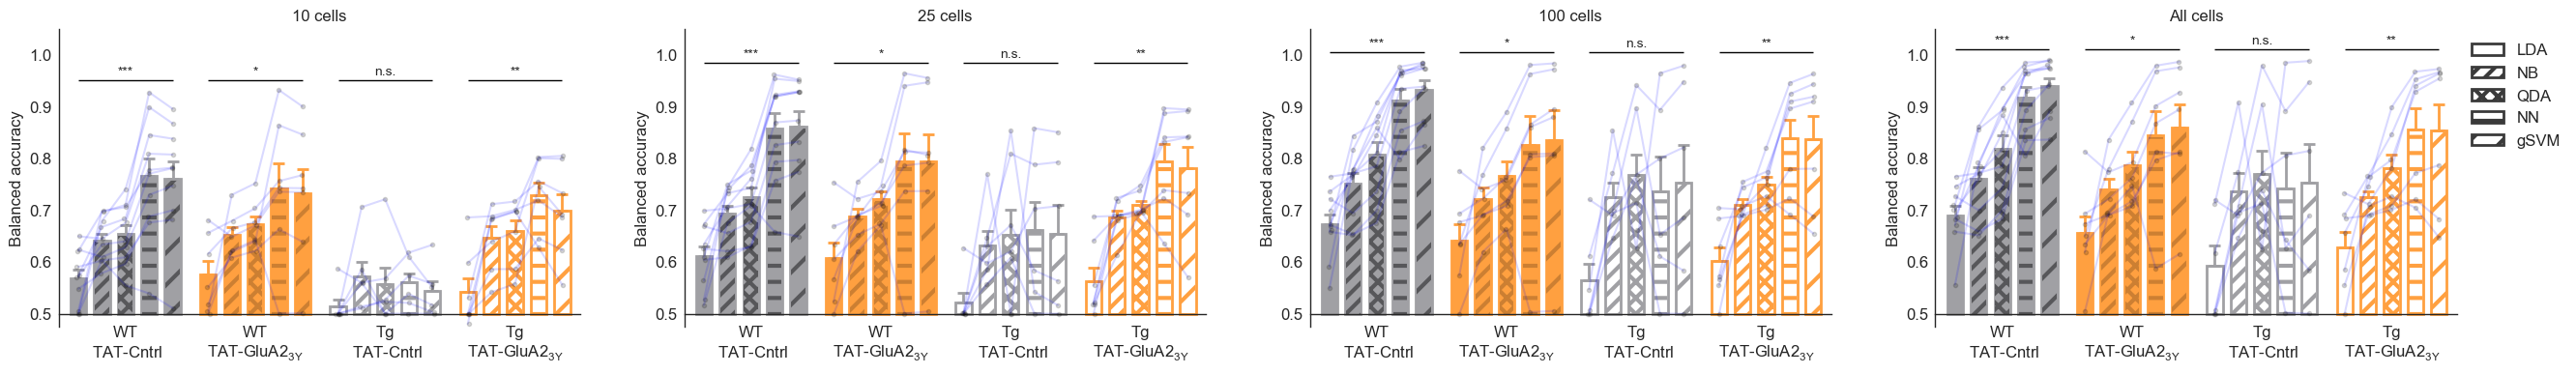

In [13]:
plot_cell_order = ['c10', 'c25', 'c100', 'baseline']
titles_c = ['10 cells', '25 cells', '100 cells', 'All cells']

fig, ax = plt.subplots(1,4, figsize=(32,4))

for ix, trial in enumerate(plot_cell_order):
    if ix == len(plot_cell_order)-1:
        show_legend = True
    else:
        show_legend = False
    bar_plot(chen_plot_trial_dict[trial], ['LDA', 'NB', 'QDA', 'NN', 'gSVM'], 
    ax=ax[ix], ylabel="Balanced accuracy", show_data=True, ylim=[.475, 1.05], bottom = 0.5, show=False, show_sample_size=False, show_legend=show_legend, 
    paired="condition", sig_th=.2, show_stat=False, label_stat=False, show_lines=True, data_alpha=0.15, data_dot_style='k.', jitter_scale=0.1) 
    #plt.hlines(0.5, -1,25, 'k')
    ax[ix].set_yticks([.5, .6, .7, .8, .9, 1.])
    ax[ix].set_title(titles_c[ix])
    max_val = np.max(sum(sum(chen_plot_trial_dict[trial], []), [])) +0.02

    sigbars([0,max_val], [4,max_val], 0, 0.01, '***', pyplot_obj=ax[ix])
    sigbars([5.5,max_val], [9.5,max_val], 0, 0.01, '*', pyplot_obj=ax[ix])
    sigbars([11,max_val], [15,max_val], 0, 0.01, 'n.s.', pyplot_obj=ax[ix])
    sigbars([16.5,max_val], [20.5,max_val], 0, 0.01, '**', pyplot_obj=ax[ix])


#plt.savefig('S2C - fixed cells 2.svg', dpi=1080, bbox_inches='tight')

#### Stats

In [14]:
trial_names_map_c = dict(zip(plot_cell_order, titles_c))
condition_names_map = dict(zip(['WT-Veh', 'WT-GluA2', 'Tg-Veh', 'Tg-GluA2'],['WT TAT-Cntrl', 'WT TAT-GluA2$3Y', 'Tg TAT-Cntrl', 'Tg TAT-GluA2$3Y']))
holder = create_holder('subsample', 'condition', 'df', 'F', 'p')

for trial in plot_cell_order:
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    for cond in condition_order:
        print(trial, cond)
        subdf = df_restricted_cells_trials.query("cell_trial == @trial and cond == @cond")
        model = ols('bacc ~ C(classifier) ', data=subdf).fit()
        res = sm.stats.anova_lm(model, typ=2)

        deg_freedom = res['df'].values.astype(int)
        deg_freedom_str = to_subscript(f"{deg_freedom[0], deg_freedom[1]}")

        fval = res['F']['C(classifier)']
        
        pval = res['PR(>F)']['C(classifier)']
        if 0.00001 < pval < 0.001:
            pval_str = 'p = '+ to_scientific_notation_str(pval)
        elif pval < 0.00001:
            pval_str = 'p < 0.0001'
        else:
            pval_str = 'p = ' + str(np.round(pval,3))

        formatted_output = f"F{deg_freedom_str} = {np.round(fval,3)}, {pval_str}"
        print(formatted_output,'\n')
        fill_holder(holder, [trial_names_map_c[trial], condition_names_map[cond], deg_freedom, fval, pval])

s2c_stats = pd.DataFrame(holder)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
c10 WT-Veh
F₍₄, ₄₅₎ = 10.592, p < 0.0001 

c10 WT-GluA2
F₍₄, ₃₀₎ = 3.464, p = 0.019 

c10 Tg-Veh
F₍₄, ₂₅₎ = 0.801, p = 0.536 

c10 Tg-GluA2
F₍₄, ₃₀₎ = 6.711, p = 5.548 × 10⁻⁴ 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
c25 WT-Veh
F₍₄, ₄₅₎ = 19.571, p < 0.0001 

c25 WT-GluA2
F₍₄, ₃₀₎ = 3.725, p = 0.014 

c25 Tg-Veh
F₍₄, ₂₆₎ = 1.452, p = 0.245 

c25 Tg-GluA2
F₍₄, ₃₀₎ = 9.644, p = 3.882 × 10⁻⁵ 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
c100 WT-Veh
F₍₄, ₄₅₎ = 25.923, p < 0.0001 

c100 WT-GluA2
F₍₄, ₃₀₎ = 3.229, p = 0.026 

c100 Tg-Veh
F₍₄, ₂₆₎ = 2.186, p = 0.099 

c100 Tg-GluA2
F₍₄, ₃₀₎ = 9.67, p = 3.801 × 10⁻⁵ 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
baseline WT-Veh
F₍₄, ₄₅₎ = 23.404, p < 0.0001 

baseline WT-GluA2
F₍₄, ₃₀₎ = 4.645, p = 0.005 

baseline Tg-Veh
F₍₄, ₂₆₎ = 1.473, p = 0.239 

baseline Tg-GluA2
F₍₄, ₃₀₎ = 6.561, p = 6.435 × 10⁻⁴ 



### S2D

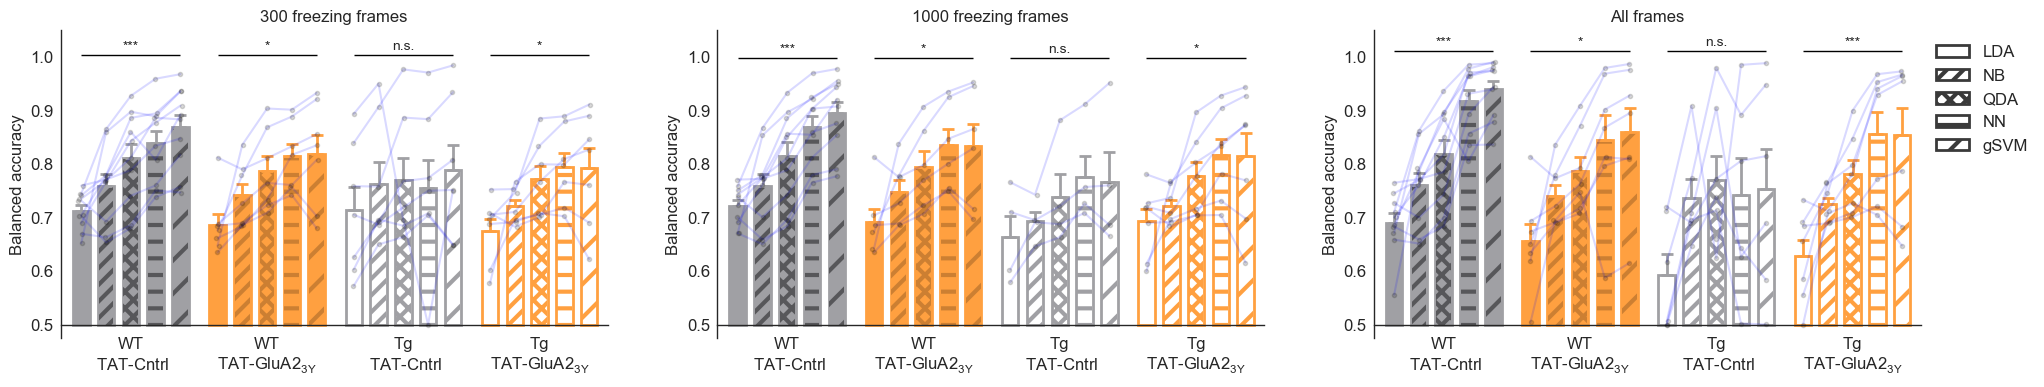

In [15]:
plot_trial_order = ['t600_updated', 't1000', 'baseline']
titles_d = ['300 freezing frames', '1000 freezing frames', 'All frames']

fig, ax = plt.subplots(1,3, figsize=(24,4))

for ix, trial in enumerate(plot_trial_order):
    if ix == len(plot_trial_order)-1:
        show_legend = True
    else:
        show_legend = False
    bar_plot(chen_plot_trial_dict[trial], ['LDA', 'NB', 'QDA', 'NN', 'gSVM'], 
    ax=ax[ix], ylabel="Balanced accuracy", show_data=True, ylim=[.475, 1.05], bottom = 0.5, show=False, show_sample_size=False, show_legend=show_legend, 
    paired="condition", sig_th=.2, show_stat=False, label_stat=False, show_lines=True, data_alpha=0.15, data_dot_style='k.', jitter_scale=0.1) 
    #plt.hlines(0.5, -1,25, 'k')
    ax[ix].set_yticks([.5, .6, .7, .8, .9, 1.])
    ax[ix].set_title(titles_d[ix])
    max_val = np.max(sum(sum(chen_plot_trial_dict[trial], []), [])) +0.02

    sigbars([0,max_val], [4,max_val], 0, 0.01, '***', pyplot_obj=ax[ix])
    sigbars([5.5,max_val], [9.5,max_val], 0, 0.01, '*', pyplot_obj=ax[ix])
    sigbars([11,max_val], [15,max_val], 0, 0.01, 'n.s.', pyplot_obj=ax[ix])
    if ix == len(plot_trial_order)-1:
        sigbars([16.5,max_val], [20.5,max_val], 0, 0.01, '***', pyplot_obj=ax[ix])
    else:
        sigbars([16.5,max_val], [20.5,max_val], 0, 0.01, '*', pyplot_obj=ax[ix])

#plt.savefig('S2D - fixed trials 2.svg', dpi=1080, bbox_inches='tight')

#### Stats

In [16]:
trial_names_map_d = dict(zip(plot_trial_order, titles_d))
condition_names_map = dict(zip(['WT-Veh', 'WT-GluA2', 'Tg-Veh', 'Tg-GluA2'],['WT TAT-Cntrl', 'WT TAT-GluA2$3Y', 'Tg TAT-Cntrl', 'Tg TAT-GluA2$3Y']))
holder = create_holder('subsample', 'condition', 'df', 'F', 'p')

for trial in plot_trial_order:
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    for cond in condition_order:
        print(trial, cond)
        subdf = df_restricted_cells_trials.query("cell_trial == @trial and cond == @cond")
        model = ols('bacc ~ C(classifier) ', data=subdf).fit()
        res = sm.stats.anova_lm(model, typ=2)

        deg_freedom = res['df'].values.astype(int)
        deg_freedom_str = to_subscript(f"{deg_freedom[0], deg_freedom[1]}")

        fval = res['F']['C(classifier)']
        
        pval = res['PR(>F)']['C(classifier)']
        if 0.00001 < pval < 0.001:
            pval_str = 'p = '+ to_scientific_notation_str(pval)
        elif pval < 0.00001:
            pval_str = 'p < 0.0001'
        else:
            pval_str = 'p = ' + str(np.round(pval,3))

        formatted_output = f"F{deg_freedom_str} = {np.round(fval,3)}, {pval_str}"
        print(formatted_output,'\n')
        fill_holder(holder, [trial_names_map_d[trial], condition_names_map[cond], deg_freedom, fval, pval])

s2d_stats = pd.DataFrame(holder)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
t600_updated WT-Veh
F₍₄, ₄₅₎ = 7.788, p = 7.381 × 10⁻⁵ 

t600_updated WT-GluA2
F₍₄, ₃₀₎ = 4.107, p = 0.009 

t600_updated Tg-Veh
F₍₄, ₃₀₎ = 0.332, p = 0.854 

t600_updated Tg-GluA2
F₍₄, ₃₀₎ = 3.469, p = 0.019 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
t1000 WT-Veh
F₍₄, ₄₅₎ = 11.382, p < 0.0001 

t1000 WT-GluA2
F₍₄, ₂₅₎ = 3.451, p = 0.022 

t1000 Tg-Veh
F₍₄, ₁₅₎ = 1.012, p = 0.432 

t1000 Tg-GluA2
F₍₄, ₃₀₎ = 3.303, p = 0.023 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
baseline WT-Veh
F₍₄, ₄₅₎ = 23.404, p < 0.0001 

baseline WT-GluA2
F₍₄, ₃₀₎ = 4.645, p = 0.005 

baseline Tg-Veh
F₍₄, ₂₆₎ = 1.473, p = 0.239 

baseline Tg-GluA2
F₍₄, ₃₀₎ = 6.561, p = 6.435 × 10⁻⁴ 



### S2E

In [17]:
df_single_cell_25c_1000t = pd.read_csv('Data/classifier_bacc_single_cell_vs_full_model_25cell_1000frame.csv')

In [18]:
condition_order = ['WT-Veh', 'WT-GluA2', 'Tg-Veh', 'Tg-GluA2']
classifier_order = ['LDA', 'NB', 'QDA', 'NN', 'gSVM']
cell_trial_order = ['c10', 'c25', 'c100', 'baseline']



full_model_chendata = []
for class_ix, classifier in enumerate(classifier_order):
    subdf = df_single_cell_25c_1000t.query("model == 'full'  and classifier == @classifier")
    # Here we groupby condition, get the bacc, convert it to a list, reorder the conditions, then make the whole thing into a list of lists
    bacc_list = subdf.groupby('cond')['bacc'].apply(list).reindex(condition_order, level='cond').tolist() 
    full_model_chendata.append(bacc_list)

Text(0.5, 1.0, '1000 freezing frames, 25 cells')

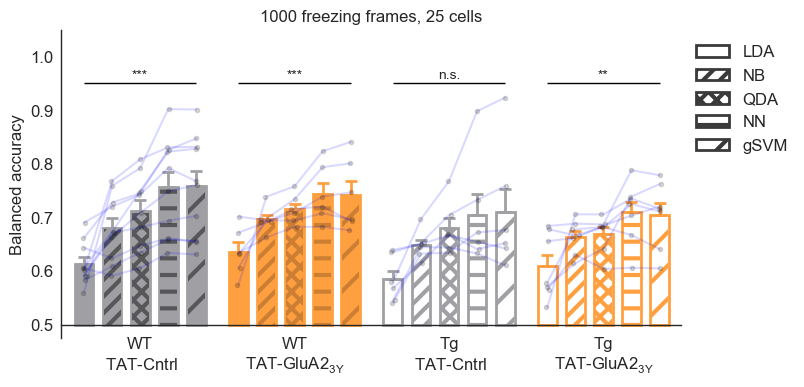

In [19]:
plt.figure(figsize=(8,4))
ax = plt.gca()
show_legend=True
bar_plot(full_model_chendata, ['LDA', 'NB', 'QDA', 'NN', 'gSVM'], 
    ax=ax, ylabel="Balanced accuracy", show_data=True, ylim=[.475, 1.05], bottom = 0.5, show=False, show_sample_size=False, show_legend=show_legend, 
    paired="condition", sig_th=.2, show_stat=False, label_stat=False, show_lines=True, data_alpha=0.15, data_dot_style='k.', jitter_scale=0.1) 

max_val = 0.95
sigbars([0,max_val], [4,max_val], 0, 0.01, '***')
sigbars([5.5,max_val], [9.5,max_val], 0, 0.01, '***')
sigbars([11,max_val], [15,max_val], 0, 0.01, 'n.s.')
sigbars([16.5,max_val], [20.5,max_val], 0, 0.01, '**')

plt.title("1000 freezing frames, 25 cells")

#plt.savefig('S2E - fixed trials and frames.svg', dpi=1080, bbox_inches='tight')

#### Stats

In [20]:
condition_names_map = dict(zip(['WT-Veh', 'WT-GluA2', 'Tg-Veh', 'Tg-GluA2'],['WT TAT-Cntrl', 'WT TAT-GluA2$3Y', 'Tg TAT-Cntrl', 'Tg TAT-GluA2$3Y']))
holder = create_holder('condition', 'df', 'F', 'p')

for cond in condition_order:
    print(cond)
    subdf = df_single_cell_25c_1000t.query("cond == @cond and model == 'full'")
    model = ols('bacc ~ C(classifier) ', data=subdf).fit()
    res = sm.stats.anova_lm(model, typ=2)

    deg_freedom = res['df'].values.astype(int)
    deg_freedom_str = to_subscript(f"{deg_freedom[0], deg_freedom[1]}")

    fval = res['F']['C(classifier)']
    
    pval = res['PR(>F)']['C(classifier)']
    if 0.00001 < pval < 0.001:
        pval_str = 'p = '+ to_scientific_notation_str(pval)
    elif pval < 0.00001:
        pval_str = 'p < 0.0001'
    else:
        pval_str = 'p = ' + str(np.round(pval,2))
    formatted_output = f"F{deg_freedom_str} = {np.round(fval,3)}, {pval_str}"
    print(formatted_output,'\n')

    fill_holder(holder, [condition_names_map[cond], deg_freedom, fval, pval])

s2e_stats = pd.DataFrame(holder)


WT-Veh
F₍₄, ₄₅₎ = 6.687, p = 2.595 × 10⁻⁴ 

WT-GluA2
F₍₄, ₂₅₎ = 5.47, p = 0.0 

Tg-Veh
F₍₄, ₂₅₎ = 2.802, p = 0.05 

Tg-GluA2
F₍₄, ₃₀₎ = 4.26, p = 0.01 



### S2F

In [21]:
df_balanced_accuracy_comparison = pd.read_csv('Data/review4_q1_q3.csv')
df_balanced_accuracy_comparison = df_balanced_accuracy_comparison.drop('Unnamed: 0', axis=1)
df_baseline = df_balanced_accuracy_comparison.query("cell_trial == 'baseline'")

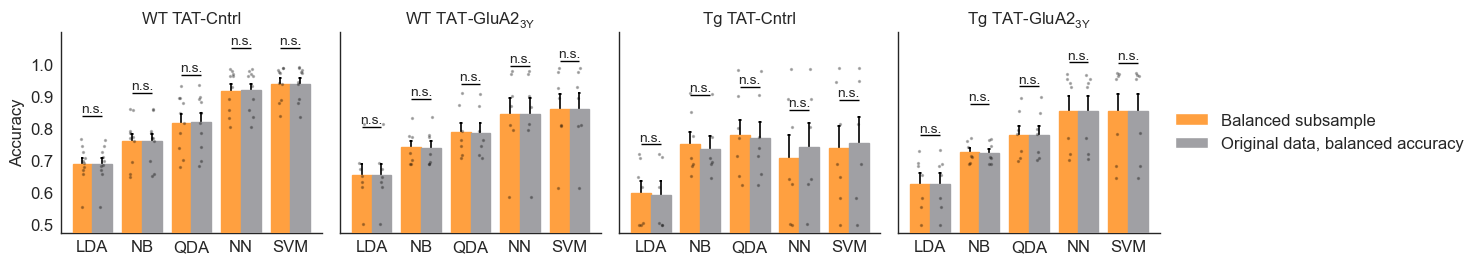

In [22]:
df_baseline_forplot = df_baseline.copy()
df_baseline_forplot['classifier_simple'] = df_baseline_forplot['classifier'].str.split('_', expand=True)[0]
df_baseline_forplot['equal_bacc_sample'] = df_baseline_forplot['equal_bacc_sample'].replace({True:'Balanced subsample', False:'Original data, balanced accuracy'})

condition_order = ['WT-Veh', 'WT-GluA2', 'Tg-Veh', 'Tg-GluA2']
classifier_order = ['LDA', 'NB', 'QDA', 'NN', 'SVM']
equal_bacc_order = ['Balanced subsample', 'Original data, balanced accuracy']

col = 'cond'
x = 'classifier'
hue = 'equal_bacc_sample'

order_dict = {'equal_bacc_sample':equal_bacc_order, 'cond':condition_order, 'classifier':classifier_order}


glua2 = "#ffa040"
veh = "#a0a0a4"
custom_palette = {'Balanced subsample': glua2, 'Original data, balanced accuracy': veh}

# Create the FacetGrid
g = sns.FacetGrid(df_baseline_forplot, col=col, col_order = order_dict[col])

# Map the barplot with customizations
g.map(sns.barplot, x, 'bacc', hue,
      errorbar='se',
      hue_order=order_dict[hue], capsize=0.07, saturation=1, err_kws={'color': 'black', 'linewidth':1.2},
      palette = custom_palette,
      order=order_dict[x],
      zorder=1)

# Add the legend and set its position
g.add_legend(title='', loc='center right')


g.set_titles("{col_name}")
axes = g.axes.flatten()
axes[0].set_ylabel('Accuracy')
g.set_xlabels('')
axes[0].set_yticks(np.arange(0.5, 1.05, 0.1))
axes[0].set_ylim(0.475,1.1)

titles = ['WT TAT-Cntrl', r'WT TAT-$GluA2_{3Y}$', 'Tg TAT-Cntrl', r'Tg TAT-$GluA2_{3Y}$']
for ax_ix, a in enumerate(axes):
      a.set_title(titles[ax_ix])
      for bar_ix, bar in enumerate(a.patches):
            bar.set_zorder(3) # Move bar up in the zorder to overlap lower errorbar
            if bar_ix in [0,1,2,3,4]:
                  bar.set_edgecolor(glua2)
                  bar_height_adj = 0.15
                  bar_height = min(bar.get_height()+bar_height_adj, 1.05)
                  sigbars([bar.xy[0]+0.2, bar_height], [bar.xy[0]+0.6, bar_height], 0, 0.01, 'n.s.', pyplot_obj=a)
            else:
                  bar.set_edgecolor(veh)

# Individual data points
jitter_amount = 0.05
point_alpha = 0.25
for col_ix, cond in enumerate(condition_order):
    for class_ix, classifier in enumerate(classifier_order):
            for equal_ix, equal in enumerate(equal_bacc_order):
                  scatter_data = df_baseline_forplot.query("cond == @cond and classifier == @classifier and equal_bacc_sample == @equal").bacc.values
                  X = [(class_ix - 0.2) + (0.4 * equal_ix)] * len(scatter_data)
                  X = X + np.random.uniform(-jitter_amount, jitter_amount, size = len(X))
                  axes[col_ix].scatter(X, scatter_data, s=2, color='k', zorder=10, alpha=point_alpha)


#plt.savefig('S2E - balanced accuracy.svg', dpi=1080, bbox_inches='tight')


Stats in prism file

### S2G

In [23]:
r4_data = open_pickle('Data/r4_plot_res.pkl')


res_to_plot = [
    "lda_bacc_res",
    "logistic_reg_bacc_res",
    "linear_svm_bacc_res",
    "mlp_bacc_res_shuffle_label",
    "mlp_bacc_res_shuffle_cell",
    "mlp_bacc_res_const_cell_25",
    "mlp_bacc_res_const_cell_50",
    "mlp_bacc_res_const_time_300",
    "mlp_bacc_res",
    ]
labels = ["LDA", "LR", "SVM", "NN_shuffle_label", "NN_shuffle_cell", "NN_25_cell", "NN_50_cell", "NN_2%", "NN"]


linear_classifier_results = [r4_data[res_name][0] for res_name in res_to_plot]

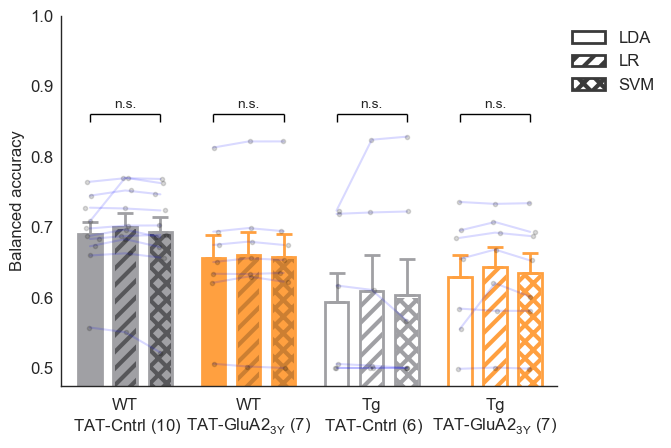

In [24]:
ax = plt.axes()
bar_plot(linear_classifier_results[:3], labels[:3], ax=ax, ylabel="Balanced accuracy", show_data=True, ylim=[.475, 1], 
    show_legend=True, paired="condition", show_lines=True, show_stat=False, show_sample_size=True,
    label_stat=False, extra_legend_pos = 10)

sigbars([0,0.85], [2,0.85], 0.01, label_height=0.01, label='n.s.')
sigbars([3.5,0.85], [5.5,0.85], 0.01, label_height=0.01, label='n.s.')
sigbars([7,0.85], [9,0.85], 0.01, label_height=0.01, label='n.s.')
sigbars([10.5,0.85], [12.5,0.85], 0.01, label_height=0.01, label='n.s.')
#plt.savefig('S2E - linear classifiers.svg', dpi=1080, bbox_inches='tight')

#### Stats

In [25]:
res = {'classifier':[], 'cond':[], 'bacc':[]}

for class_ix, classifier in enumerate(labels[:3]):
    for cond_ix, cond in enumerate(condition_order):
        baccs = linear_classifier_results[class_ix][cond_ix]

        for b in baccs:
            res['classifier'].append(classifier)
            res['cond'].append(cond)
            res['bacc'].append(b)

df_linear_classifier = pd.DataFrame(res)

In [26]:
condition_names_map = dict(zip(['WT-Veh', 'WT-GluA2', 'Tg-Veh', 'Tg-GluA2'],['WT TAT-Cntrl', 'WT TAT-GluA2$3Y', 'Tg TAT-Cntrl', 'Tg TAT-GluA2$3Y']))
holder = create_holder('condition', 'df', 'F', 'p')

for cond in condition_order:
    print(cond)
    subdf = df_linear_classifier.query("cond == @cond")
    model = ols('bacc ~ C(classifier) ', data=subdf).fit()
    res = sm.stats.anova_lm(model, typ=2)

    deg_freedom = res['df'].values.astype(int)
    deg_freedom_str = to_subscript(f"{deg_freedom[0], deg_freedom[1]}")

    fval = res['F']['C(classifier)']
    
    pval = res['PR(>F)']['C(classifier)']
    if 0.00001 < pval < 0.001:
        pval_str = 'p = '+ to_scientific_notation_str(pval)
    elif pval < 0.00001:
        pval_str = 'p < 0.0001'
    else:
        pval_str = 'p = ' + str(np.round(pval,2))
    formatted_output = f"F{deg_freedom_str} = {np.round(fval,3)}, {pval_str}"
    print(formatted_output,'\n')

    fill_holder(holder, [condition_names_map[cond], deg_freedom, fval, pval])

s2g_stats = pd.DataFrame(holder)

WT-Veh
F₍₂, ₂₇₎ = 0.061, p = 0.94 

WT-GluA2
F₍₂, ₁₈₎ = 0.003, p = 1.0 

Tg-Veh
F₍₂, ₁₅₎ = 0.022, p = 0.98 

Tg-GluA2
F₍₂, ₁₈₎ = 0.047, p = 0.95 



### S2H

In [27]:
activity_hyper_removed = open_pickle('Data/mlp_no_top_res.pkl')
activity_uncorrected = open_pickle('Data/act_res.pkl')


# Left panel
wt = np.concatenate(activity_uncorrected[1][0])
tg = np.concatenate(activity_uncorrected[1][2])
no_hyp = np.concatenate(activity_hyper_removed['masked_act_res'][0][2])

labels = ['wt']*len(wt) + ['tg']*len(tg) + ['tg_no_hyp']*len(no_hyp)
labels_clean = ['WT + Tat-Cntrl']*len(wt) + ['Tg + TAT-Cntrl']*len(tg) + ['Tg + TAT-Cntrl with top 10% \n active cells removed']*len(no_hyp)
df_activity = pd.DataFrame({'label':labels, 'activity':np.concatenate([wt,tg,no_hyp]), 'label_clean':labels_clean})

In [28]:
# Right panel

mlp_bacc_res = open_pickle('Data/mlp_bacc_res.pkl')

wt_bacc = mlp_bacc_res[0][0]
tg_bacc = mlp_bacc_res[0][2]
no_hyp_bacc = activity_hyper_removed['mlp_no_top_act_bacc_res'][0][2]

labels_bacc = ['wt']*len(wt_bacc) + ['tg']*len(tg_bacc) + ['tg_no_hyp']*len(no_hyp_bacc)
labels_clean = ['WT + Tat-Cntrl']*len(wt_bacc) + ['Tg + TAT-Cntrl']*len(tg_bacc) + ['Tg + TAT-Cntrl with top 10% \n active cells removed']*len(no_hyp_bacc)

df_s2h_bacc = pd.DataFrame({'label':labels_bacc, 'accuracy':np.concatenate([wt_bacc,tg_bacc,no_hyp_bacc]), 'label_clean':labels_clean})

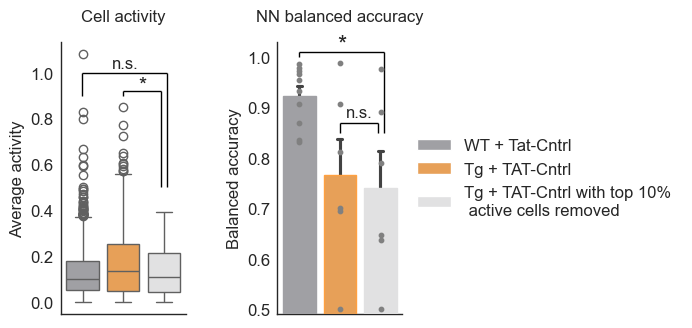

In [29]:
colours_s2h = ['#a0a0a4', '#ffa040', '#e1e1e2']
pal = sns.color_palette(colours_s2h)

fig, ax = plt.subplots(1,3, figsize=(7,4))
fig.tight_layout(pad = 3)
ax[2].axis('off')


sns.boxplot(data=df_activity, y='activity', hue='label', palette=pal, gap=0.2, ax = ax[0], legend=False)
ax[0].set_ylabel('Average activity')
ax[0].set_title('Cell activity', pad=15)

g = sns.barplot(data=df_s2h_bacc, y='accuracy', hue='label_clean', palette=pal, gap=0.2, errorbar='se', capsize=.1, legend='auto', ax = ax[1], width=0.8)

g.legend_.set_title(None)
ax[1].legend(frameon=False)
sns.move_legend(g, 'center left', bbox_to_anchor=(1, 0.5))

ax[1].set_ylabel('Balanced accuracy')
ax[1].set_ylim(0.49,1.03)
ax[1].set_title('NN balanced accuracy', pad=15)

for b_ix, bar in enumerate(g.patches[:3]):
    bar.set_zorder(3)
    bar.set_edgecolor(colours_s2h[b_ix])

X = np.arange(-.2675, .2676, .2675)
for ix, lab in enumerate(df_s2h_bacc.label.unique()):
    data = df_s2h_bacc[df_s2h_bacc.label == lab].accuracy.values
    ax[1].scatter([X[ix]]*len(data), data, zorder=10, color='gray', s=10)

sigbars([-.2675, 0.9], [.29,.5], height=.1, label_height = 0.02, pyplot_obj = ax[0], fontsize=12, label='n.s.')
sigbars([0, .9], [.25,.5], height=0.02, label_height = 0.001, pyplot_obj = ax[0], fontsize=15)

sigbars([-.2675, 1], [.29,.85], height=0.01, label_height = 0.001, pyplot_obj = ax[1], fontsize=17)
sigbars([0, .85], [.25,.85], height=0.02, label_height = 0.01, pyplot_obj = ax[1], fontsize=12, label='n.s.')

#plt.savefig('Fig S2H.svg', dpi=1080)

#### Stats

In [30]:
model = ols('activity ~ C(label) ', data=df_activity).fit()
res = sm.stats.anova_lm(model, typ=2)
deg_freedom = res['df'].values.astype(int)
fval = res['F']['C(label)']
pval = res['PR(>F)']['C(label)']

s2h_stats_left = pd.DataFrame(columns = ['condition', 'df', 'F', 'p'], data = [['Cell activity', deg_freedom, fval, pval]])


model = ols('accuracy ~ C(label) ', data=df_s2h_bacc).fit()
res = sm.stats.anova_lm(model, typ=2)
deg_freedom = res['df'].values.astype(int)
fval = res['F']['C(label)']
pval = res['PR(>F)']['C(label)']

s2h_stats_right = pd.DataFrame(columns = ['condition', 'df', 'F', 'p'], data = [['Balanced accuracy', deg_freedom, fval, pval]])

s2h_stats = pd.concat([s2h_stats_left, s2h_stats_right]).reset_index(drop=True)

In [31]:
print(sm.stats.multicomp.pairwise_tukeyhsd(df_activity.activity, df_activity.label))

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
       tg tg_no_hyp  -0.0361    0.0 -0.0526 -0.0197   True
       tg        wt  -0.0419    0.0 -0.0561 -0.0278   True
tg_no_hyp        wt  -0.0058 0.6229 -0.0204  0.0089  False
----------------------------------------------------------


In [32]:
print(sm.stats.multicomp.pairwise_tukeyhsd(df_s2h_bacc.accuracy, df_s2h_bacc.label))

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
       tg tg_no_hyp  -0.0268 0.9361 -0.2234 0.1698  False
       tg        wt   0.1564 0.0867 -0.0195 0.3322  False
tg_no_hyp        wt   0.1832 0.0403  0.0073  0.359   True
---------------------------------------------------------


### S2I

In [33]:
pairwise_corr_data = open_pickle('Data/pairwise_corr_res_per_animal.pkl')

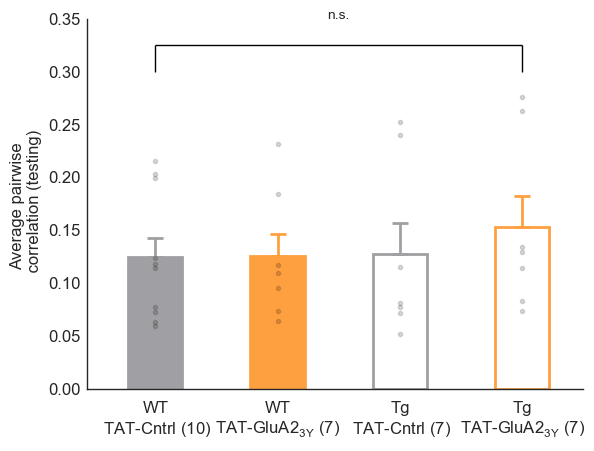

In [34]:
ax = plt.axes()
bar_plot([pairwise_corr_data[0]], ['Pairwise correlation'], ax=ax, ylabel='Average pairwise \n correlation (testing)', show_data=True, ylim=[0, 0.35], show_legend=False, 
         paired="condition", show_lines=True, show_stat=False, label_stat=False, extra_legend_pos = 10, jitter_scale = 0.0035, show_sample_size=True)
sigbars([0,0.30], [4.5,0.30], 0.025, label_height=0.025, label='n.s.')

#plt.savefig('S2G - pairwise correlation.svg', dpi=1080, bbox_inches='tight')

#### Stats

In [35]:
res = {'cond':[], 'bacc':[]}


for cond_ix, cond in enumerate(condition_order):
    baccs = pairwise_corr_data[0][cond_ix]

    for b in baccs:
        res['cond'].append(cond)
        res['bacc'].append(b)

df_pairwise_corr = pd.DataFrame(res)

In [36]:
model = ols('bacc ~ C(cond) ', data=df_pairwise_corr).fit()
res = sm.stats.anova_lm(model, typ=2)
res

,sum_sq,df,F,PR(>F)
C(cond),0.004156,3.0,0.270593,0.846028
Residual,0.138234,27.0,NaN,NaN


In [37]:
deg_freedom = res['df'].values.astype(int)
fval = res['F']['C(cond)']
pval = res['PR(>F)']['C(cond)']

s2i_stats = pd.DataFrame(columns = ['df', 'F', 'p'], data = [[deg_freedom, fval, pval]])

### S2J

In [38]:
df_single_cell_model = pd.read_csv('Data/classifier_bacc_single_cell_vs_full_model.csv')

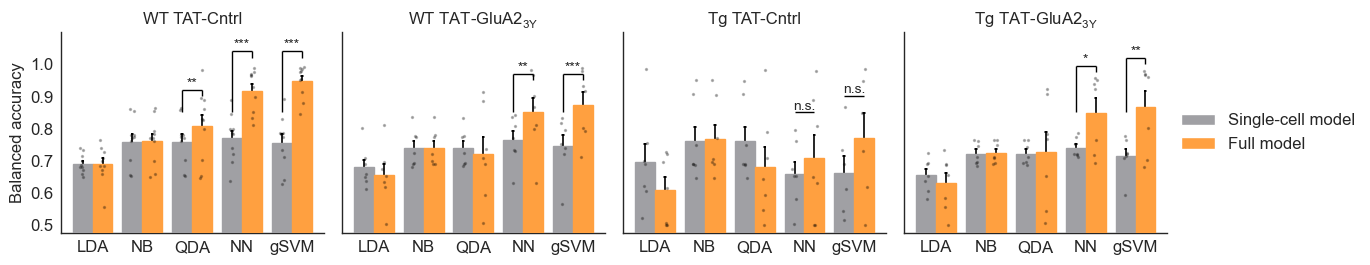

In [39]:
df_no_lr = df_single_cell_model[~df_single_cell_model['classifier'].str.contains('LR_')]
df_sns_condition = df_no_lr.copy()
df_sns_condition['classifier_simple'] = df_sns_condition['classifier'].str.split('_', expand=True)[0]
df_sns_condition['sc_type'] = df_sns_condition['sc_type'].replace({'sc':'Single-cell model', 'full':'Full model'})

condition_order = ['WT-Veh', 'WT-GluA2', 'Tg-Veh', 'Tg-GluA2']
classifier_order = ['LDA', 'NB', 'QDA', 'NN', 'gSVM']
sc_order = ['Single-cell model', 'Full model']

col = 'full_cond'
x = 'classifier_simple'
hue = 'sc_type'

order_dict = {'sc_type':sc_order, 'full_cond':condition_order, 'classifier_simple':classifier_order}


glua2 = "#ffa040"
veh = "#a0a0a4"
custom_palette = {'Single-cell model': veh, 'Full model': glua2}
pal = sns.color_palette("tab10")

# Create the FacetGrid
g = sns.FacetGrid(df_sns_condition, col=col, col_order = order_dict[col])

# Map the barplot with customizations
g.map(sns.barplot, x, 'bacc', hue,
      errorbar='se',
      hue_order=order_dict[hue], capsize=0.07, saturation=1, err_kws={'color': 'black', 'linewidth':1.2},
      palette = custom_palette,
      order=order_dict[x],
      zorder=1)

# Add the legend and set its position
g.add_legend(title='', loc='center right')


g.set_titles("{col_name}")
axes = g.axes.flatten()
axes[0].set_ylabel('Balanced accuracy')
g.set_xlabels('')
axes[0].set_yticks(np.arange(0.5, 1.05, 0.1))
axes[0].set_ylim(0.475,1.1)

titles = ['WT TAT-Cntrl', r'WT TAT-$GluA2_{3Y}$', 'Tg TAT-Cntrl', r'Tg TAT-$GluA2_{3Y}$']
for ax_ix, a in enumerate(axes):
      a.set_title(titles[ax_ix])
      for bar_ix, bar in enumerate(a.patches):
            bar.set_zorder(3) # Move bar up in the zorder to overlap lower errorbar
            if bar_ix in [0,1,2,3,4]:
                  bar.set_edgecolor(veh)
            else:
                  bar.set_edgecolor(glua2)


# Sigbars
sigbars([1.8, 0.85], [2.2, 0.9], 0.02, 0.01, '**', pyplot_obj=axes[0])
sigbars([2.8, 0.85], [3.2, 1.02], 0.02, 0.01, '***', pyplot_obj=axes[0])
sigbars([3.8, 0.85], [4.2, 1.02], 0.02, 0.01, '***', pyplot_obj=axes[0])

sigbars([2.8, 0.85], [3.2, 0.95], 0.02, 0.01, '**', pyplot_obj=axes[1])
sigbars([3.8, 0.85], [4.2, 0.95], 0.02, 0.01, '***', pyplot_obj=axes[1])

sigbars([2.8, 0.85], [3.2, 0.85], 0.00, 0.01, 'n.s.', pyplot_obj=axes[2])
sigbars([3.8, 0.9], [4.2, 0.9], 0.0, 0.01, 'n.s.', pyplot_obj=axes[2])

sigbars([2.8, 0.85], [3.2, 0.975], 0.02, 0.01, '*', pyplot_obj=axes[3])
sigbars([3.8, 0.85], [4.2, 1], 0.02, 0.01, '**', pyplot_obj=axes[3])

# Individual data points
jitter_amount = 0.05
point_alpha = 0.25
for col_ix, cond in enumerate(condition_order):
    for class_ix, classifier in enumerate(classifier_order):
            for sc_ix, sc in enumerate(sc_order):
                  scatter_data = df_sns_condition.query("full_cond == @cond and classifier_simple == @classifier and sc_type == @sc").bacc.values
                  X = [(class_ix - 0.2) + (0.4 * sc_ix)] * len(scatter_data)
                  X = X + np.random.uniform(-jitter_amount, jitter_amount, size = len(X))
                  axes[col_ix].scatter(X, scatter_data, s=2, color='k', zorder=10, alpha=point_alpha)

#plt.savefig('S2I - single cell models.svg', dpi=1080, bbox_inches='tight')

Stats in prism

### S2K

In [40]:
df_single_cell_25c_1000t.cond = df_single_cell_25c_1000t.cond.str.replace('_', '-')

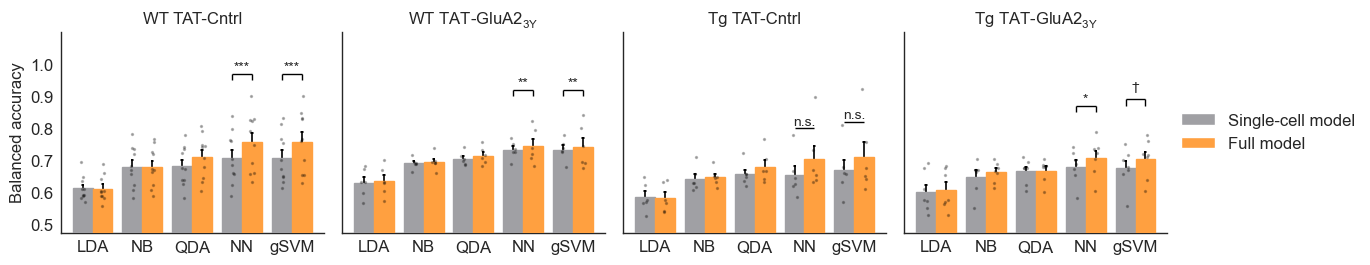

In [41]:
df_single_cell_25c_1000t = pd.read_csv('Data/classifier_bacc_single_cell_vs_full_model_25cell_1000frame.csv')

df_sns_condition = df_single_cell_25c_1000t.copy()
df_sns_condition['model'] = df_sns_condition['model'].replace({'sc':'Single-cell model', 'full':'Full model'})

condition_order = ['WT-Veh', 'WT-GluA2', 'Tg-Veh', 'Tg-GluA2']
classifier_order = ['LDA', 'NB', 'QDA', 'NN', 'gSVM']
sc_order = ['Single-cell model', 'Full model']

col = 'cond'
x = 'classifier'
hue = 'model'

order_dict = {'model':sc_order, 'cond':condition_order, 'classifier':classifier_order}


glua2 = "#ffa040"
veh = "#a0a0a4"
custom_palette = {'Single-cell model': veh, 'Full model': glua2}
pal = sns.color_palette("tab10")

# Create the FacetGrid
g = sns.FacetGrid(df_sns_condition, col=col, col_order = order_dict[col])

# Map the barplot with customizations
g.map(sns.barplot, x, 'bacc', hue,
      errorbar='se',
      hue_order=order_dict[hue], capsize=0.07, saturation=1, err_kws={'color': 'black', 'linewidth':1.2},
      palette = custom_palette,
      order=order_dict[x],
      zorder=1)

# Add the legend and set its position
g.add_legend(title='', loc='center right')


g.set_titles("{col_name}")
axes = g.axes.flatten()
axes[0].set_ylabel('Balanced accuracy')
g.set_xlabels('')
axes[0].set_yticks(np.arange(0.5, 1.05, 0.1))
axes[0].set_ylim(0.475,1.1)

titles = ['WT TAT-Cntrl', r'WT TAT-$GluA2_{3Y}$', 'Tg TAT-Cntrl', r'Tg TAT-$GluA2_{3Y}$']
for ax_ix, a in enumerate(axes):
      a.set_title(titles[ax_ix])
      for bar_ix, bar in enumerate(a.patches):
            bar.set_zorder(3) # Move bar up in the zorder to overlap lower errorbar
            if bar_ix in [0,1,2,3,4]:
                  bar.set_edgecolor(veh)
            else:
                  bar.set_edgecolor(glua2)


# Sigbars

sigbars([2.8, 0.95], [3.2, 0.95], 0.02, 0.01, '***', pyplot_obj=axes[0])
sigbars([3.8, 0.95], [4.2, 0.95], 0.02, 0.01, '***', pyplot_obj=axes[0])

sigbars([2.8, 0.9], [3.2, 0.9], 0.02, 0.01, '**', pyplot_obj=axes[1])
sigbars([3.8, 0.9], [4.2, 0.9], 0.02, 0.01, '**', pyplot_obj=axes[1])

sigbars([2.8, 0.8], [3.2, 0.8], 0.00, 0.01, 'n.s.', pyplot_obj=axes[2])
sigbars([3.8, 0.82], [4.2, 0.82], 0.0, 0.01, 'n.s.', pyplot_obj=axes[2])

sigbars([2.8, 0.85], [3.2, 0.85], 0.02, 0.01, '*', pyplot_obj=axes[3])
sigbars([3.8, 0.87], [4.2, 0.87], 0.02, 0.03, '†', pyplot_obj=axes[3], fontsize=10)

# Individual data points
jitter_amount = 0.05
point_alpha = 0.25
for col_ix, cond in enumerate(condition_order):
    for class_ix, classifier in enumerate(classifier_order):
            for sc_ix, sc in enumerate(sc_order):
                  scatter_data = df_sns_condition.query("cond == @cond and classifier == @classifier and model == @sc").bacc.values
                  X = [(class_ix - 0.2) + (0.4 * sc_ix)] * len(scatter_data)
                  X = X + np.random.uniform(-jitter_amount, jitter_amount, size = len(X))
                  axes[col_ix].scatter(X, scatter_data, s=2, color='k', zorder=10, alpha=point_alpha)

#plt.savefig('S2K - single cell models restricted cells and frames.svg', dpi=1080, bbox_inches='tight')

Stats in prism

# docx export

In [42]:
stat_file_list = [s2a_stats, s2c_stats, s2d_stats, s2e_stats, s2g_stats, s2h_stats, s2i_stats]
#stat_file_list = [s2h_stats]

panel_letters = ['A', 'C', 'D', 'E', 'G', 'H', 'I']
#panel_letters = ['H']
table_titles = [f'Figure S2{i}' for i in panel_letters]

stat_files_and_titles = dict(zip(table_titles, stat_file_list))


In [43]:
doc = Document()


for table_title, stat_file in stat_files_and_titles.items():
    

    # Check what kind of df it is, and set values
    if 'subsample' in stat_file.columns:
        n_subsamples = len(stat_file.subsample.unique())
        n_rows = len(stat_file) + n_subsamples*2
    else:
        n_subsamples = 1
        n_rows = len(stat_file) + 1

    if 'condition' in stat_file.columns:
        n_conditions = len(stat_file.condition.unique())
        block_size = n_conditions + 2 # Each reporting section block is the number of conditions reported, plus a row for the heading, plus a row of space at the end
    else:
        n_conditions = 1
        block_size = 1


    # Create a table
    table = doc.add_table(rows=n_rows, cols=4)
    table.style = 'Table Grid'

    #table.cell(0,0).text = 'Figure S2C'
    p=table.cell(0,0).add_paragraph()
    run = p.add_run(table_title)
    run.font.bold = True

    # Add headings for each subsample
    if n_subsamples > 1:
        for i in range(n_subsamples):
            row_id = 1 + (i*block_size)
            table.cell(row_id, 0).text = stat_file.subsample.unique()[i]
            # Merge across row
            c1, c2, c3, c4 = table.cell(row_id,0), table.cell(row_id,1), table.cell(row_id,2), table.cell(row_id,3)
            c1.merge(c2)
            c1.merge(c3)
            c1.merge(c4)

    # Add F test data
    for s_ix in range(n_subsamples): 

        if n_subsamples > 1:  # Only do this if there are subsample types in the stat file
            subsample = stat_file.subsample.unique()[s_ix]
            subdf = stat_file.query("subsample == @subsample").reset_index()
            starting_row = 2 + (s_ix * block_size)
        else:
            subdf = stat_file.copy()
            starting_row = 1
            
        for df_ix, row in subdf.iterrows():
            row_id = starting_row + df_ix

            #Add test type
            if df_ix == 0:
                table.cell(row_id, 0).text = 'One-way ANOVA'
            if n_conditions == 2 and df_ix == 1:  # Special case for when there are just two conditions (s2h)
                c1, c2 = table.cell(row_id,0), table.cell(row_id-1,0)
                c1.merge(c2)
            if df_ix == 3: # Most cases default to 4 conditions
                c1, c2, c3, c4 = table.cell(row_id,0), table.cell(row_id-1,0), table.cell(row_id-2,0), table.cell(row_id-3,0)
                c1.merge(c2)
                c1.merge(c3)
                c1.merge(c4)

            # Format condition, if present
            if n_conditions > 1:
                if '$' in row.condition:
                    reg, sub = row.condition.split('$')
                    add_formatted_text(table.cell(row_id,1), [(reg, 'normal'), (sub, 'subscript')])
                else:
                    table.cell(row_id,1).text = row.condition

            # Format DF
            add_formatted_text(table.cell(row_id, 2), [('F', 'normal'),(str(tuple(row.df)), 'subscript'), (f' = {np.round(row.F,2)}', 'normal')])
        
            # Format p-value
            if 0.01 > row.p > 0.00001:
                base, exponent = to_scientific_notation(row.p)
                add_formatted_text(table.cell(row_id, 3), [(f'p = {base} × 10', 'normal'), (exponent, 'superscript')])
            elif row.p < 0.00001:
                table.cell(row_id, 3).text = 'p < 0.0001'
            else:
                table.cell(row_id, 3).text = f'p = {np.round(row.p,2)}'

    doc.add_paragraph('')


#doc.save('Figure S2 stats report python.docx')